## BANNs Example Run

### Introduction
In this Jupyter notebook, we demonstrate how to run BANNs and access the model output on a sample dataset. 



### Simulating Data
We will first simulate the sample data and pick which SNPs and SNP-sets are supposed to be the real associated values.


In [1]:
import numpy as np
np.random.seed(111) # We will seed the random number generator of numpy for reproducible results

############### SIMULATING GENOTYPES #################
# Defining the parameters of the simulated genotype matrix:
N=500 #Number of samples (or "individuals")
p=1000 #Number of SNPs

# Randomly assign a minor allele frequency (maf) value to each SNP (limiting the range to 0.05 - 0.5 in this simulation):
maf = 0.05 + 0.45*np.random.uniform(size=p)
# Simulate the genotype matrix based on maf values for each SNP. 
# If the random allele frequencies we generate in the simulation step below is larger than the corresponding maf 
X = ((np.random.uniform(size=[N,p])>maf)&(np.random.uniform(size=[N,p])>maf))*1.0

# Center and scale (z-score standardize) the genotype matrix:
Xmean= np.mean(X, axis=0) #mean of each column, which corresponds to a SNP locus
Xstd= np.std(X,axis=0) #standard deviation of each column
X=np.nan_to_num((X-Xmean)/Xstd) #Final standardized simulated genotype matrix

print("Dimensions of genotype matrix:", X.shape)
print("Number of samples:", N, " Number of SNPs:",p)

Dimensions of genotype matrix: (500, 1000)
Number of samples: 500  Number of SNPs: 1000


In [2]:
############### SIMULATING PHENOTYPES #################
# Defining the parameters of the phenotype simulations:

H2 = 0.6 #Broad-sense heritability, meaning 60% of phenotypic variation is explained by genotypic variation.
rho= 1 #All of the heritability comes from additive effects
causal_indices=np.arange(0,10) #Pick the first 10 of 1000 SNPs to have non-zero effect sizes
ncausal=len(causal_indices)

# Simulate phenotype data based on additive effects:

Xadditive=X[:, causal_indices] # Get the causal SNP values
betaAdd= np.repeat(1, ncausal)# Initialize all effect sizes for these SNPs as "1"
#Initialize the value of the portion of phenotypic variation explained by the additive effects as XB:
y_additive=np.dot(Xadditive, betaAdd)
# Re-scale additive effect sizes based on H^2*rho:
betaAdd= betaAdd * np.sqrt(H2*rho/np.var(y_additive))
# Update y_additive based on effect sizes:
y_additive=np.dot(Xadditive, betaAdd) 

# Simulate random noise (drawn from standard normal distribution) for the rest of phenotypic variation (40%):
y_noise = np.random.normal(size=N)
y_noise = y_noise * np.sqrt((1 - H2) / np.var(y_noise))

# Add y_additive and y_noise to get the final simulated phenotypes:
y = np.add(y_additive.reshape(N, 1), y_noise.reshape(N, 1)) 
print("Shape of the phenotype array:", y.shape)

Shape of the phenotype array: (500, 1)


In [3]:
############## SIMULATE THE ANNOTATION MASK #################
# While annotation.py script can be used to create biological annotations from SNP List and gene list files,
# we will create a simple annotation mask here, where every five SNP falls into one SNP-set in order:

nSNPs= p #Number of SNPs
nSets= int(p/5) #Number of SNP-sets 
mask=np.zeros(shape=(nSNPs,nSets)) #Initialize annotation mask as a matrix of zeros of size nSNPs by nSets

for i in range(0,nSets):#iterating over the columns of the annotation matrix, which correspond to SNP-sets
	for j in range(i*5,(i+1)*5): #iterating over the rows of the annotation matrix, which correspond to SNPs
		mask[j,i]=1 #Make corresponding 5 SNPs fall into the corresponding SNPsets by turning these values to "1"

print("The shape of the annotation mask is:", mask.shape)
print("Number of SNPs:",mask.shape[0], " Number of SNP-sets:", mask.shape[1])
print("This is what the annotation mask looks like:")
print(mask)

#### Save files:
np.savetxt("Xtest2.txt", X, delimiter=" ")
np.savetxt("ytest2.txt", y, delimiter=" ")
np.savetxt("masktest2.txt",mask, delimiter=" ")

The shape of the annotation mask is: (1000, 200)
Number of SNPs: 1000  Number of SNP-sets: 200
This is what the annotation mask looks like:
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


### Running BANNs model on the simulated data:
Based on the simulation scheme above, we expect the first 10 SNPs and the first 2 SNP-sets to be picked to be associated with the phenotype by BANNs model. Let's run it:

Welcome to BANNs. Please make sure SNPs in the SNP List you provide are in the same order as in the genotype matrix. Results we return will be in the order of SNP annotations and SNP-set annotations.
(500,)
20/20 [==============================] - 16s 795ms/step
(500,)
20/20 [==============================] - 4s 206ms/step
PVE
0.6276360168462365
0.6106107547232769


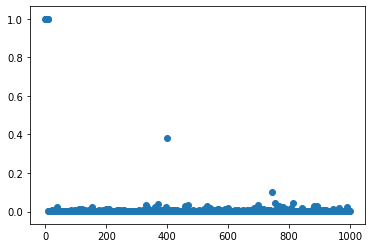

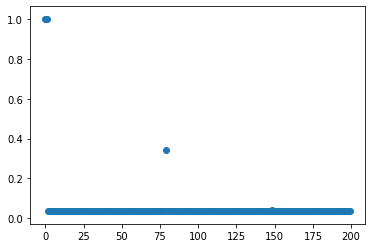

In [5]:
# Importing annotation.py from the src folder:
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../src/') #Need to do this for this notebook example since the code lives in a different directory 

from BANN import * # Import annotation code

#Changing back to the original directory:
sys.path.insert(0, '../examples_docs/')

X = np.loadtxt("Xtest2.txt")
y = np.loadtxt("ytest2.txt")
mask = np.loadtxt("masktest2.txt")

bann=BANNs(X,y, mask, nModelsSNP=20, nModelsSET=20)
[SNP_layer, SET_layer]=bann.run()
print("PVE")
print(SNP_layer.pve)
print(SET_layer.pve)


SNPpips=SNP_layer.pip
SETpips=SET_layer.pip
plt.scatter(np.arange(len(SNPpips)), SNPpips)
plt.show()

plt.scatter(np.arange(len(SETpips)), SETpips)
plt.show()

### Computational Power
ROC curves